In [1]:
# Clone Guray's repo
!rm -rf SingleScanAnalysis

!git clone https://github.com/gurayerus/SingleScanAnalysis.git
!cp SingleScanAnalysis/test/input/* .
!cp SingleScanAnalysis/src/pipeline_dl/utils_mri.py .
!cp SingleScanAnalysis/src/pipeline_dl/calc_ravens.py .


# Skull stripped images
# !cp SingleScanAnalysis/src/pipeline_istag/RAVENS_Pipeline_Simple/input/Subj1/Subj1_T1_LPS_dlicv.nii.gz .
# !cp SingleScanAnalysis/src/pipeline_istag/RAVENS_Pipeline_Simple/templates/colin27_t1_tal_lin.nii.gz .




Cloning into 'SingleScanAnalysis'...
remote: Enumerating objects: 223, done.
remote: Total 223 (delta 0), reused 0 (delta 0), pack-reused 223 (from 2)
Receiving objects: 100% (223/223), 285.64 MiB | 98.09 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# Packages from GitHub.
!pip -q install git+https://github.com/adalca/neurite.git@0776a575eadc3d10d6851a4679b7a305f3a31c65
!pip -q install git+https://github.com/freesurfer/surfa.git@ec5ddb193fd1caf22ec654c457b5678f6bd8e460
!pip -q install git+https://github.com/voxelmorph/voxelmorph.git@2cd706189cb5919c6335f34feec672f05203e36b

In [3]:
# !pip install tensorflow==2.18
# !pip install keras==3.08

# !pip show tensorflow
# !pip show keras
# !conda env list

In [24]:
!pip -q install nilearn

In [5]:
import numpy as np
import surfa as sf
import tensorflow as tf
import voxelmorph as vxm
import matplotlib.pyplot as plt

In [6]:
# Downloads.
# %%sh
# curl -O https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

!curl -O https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (60) SSL certificate problem: self-signed certificate in certificate chain
More details here: https://curl.se/docs/sslcerts.html

curl failed to verify the legitimacy of the server and therefore could not
establish a secure connection to it. To learn more about this situation and
how to fix it, please visit the webpage mentioned above.


In [7]:
# Helper functions. The shape has to be divisible by 16.
shape = (128, 128, 128)

def normalize(x):
    x = np.float32(x)
    x -= x.min()
    x /= x.max()
    return x[None, ..., None]


def show(x, title=None):
  x = np.squeeze(x)
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  i, j, k = (f // 2 for f in x.shape)

  slices = x[:, j, :], x[:, :, k], x[i, :, :].T
  for x, ax in zip(slices, axes):
    ax.imshow(x, cmap='gray')
    ax.set_axis_off()

  if title:
    axes[1].text(0.50, 1.05, title, ha='center', transform=axes[1].transAxes, size=14)

In [8]:
# # OG Pipeline files
# t1_og = sf.load_volume('../temp_files/Subj1_T1_LPS_dlicv.nii.gz')
# show(t1_og, title='Subj1_T1_LPS_dlicv')

# t1_tem = sf.load_volume('../temp_files/colin27_t1_tal_lin.nii.gz')
# show(t1_tem, title='Subj1_T1_LPS_dlicv')

# t1_seg = sf.load_volume('../temp_files/Subj1_T1_LPS_dlicv_fast_seg.nii.gz')
# show(t1_seg, title='Subj1_T1_LPS_dlicv_fast_seg')



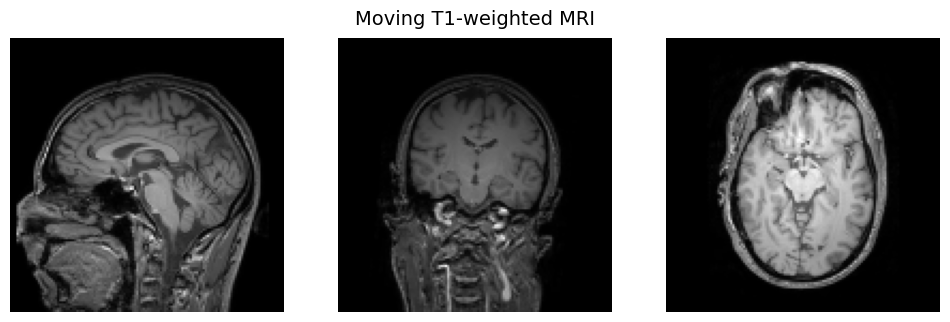

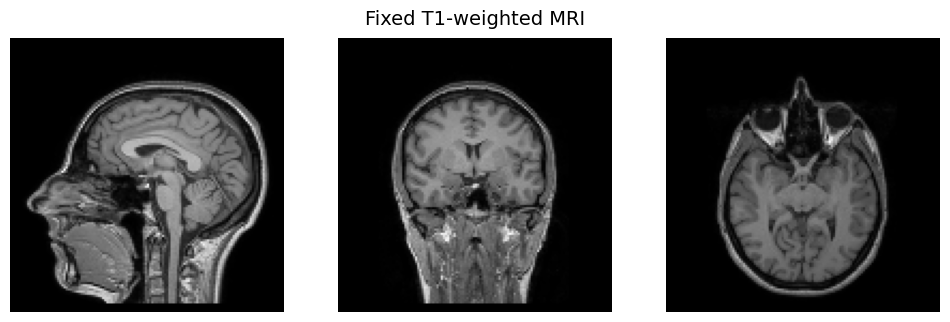

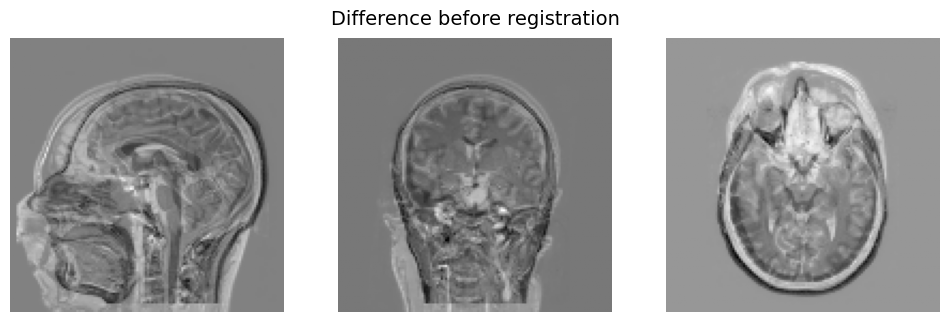

In [9]:
# Difference before registration.
t1_fixed = sf.load_volume('Img1_T1.nii.gz').resize(voxsize=2).reshape(shape).reorient('ILP')
t1_moving = sf.load_volume('Img2_T1.nii.gz').resample_like(t1_fixed)

# Skull stripped images
# t1_fixed = sf.load_volume('Subj1_T1_LPS_dlicv.nii.gz').resize(voxsize=2).reshape(shape).reorient('ILP')
# t1_moving = sf.load_volume('colin27_t1_tal_lin.nii.gz').resample_like(t1_fixed)


before = normalize(t1_moving) - normalize(t1_fixed)

show(t1_moving, title='Moving T1-weighted MRI')
show(t1_fixed, title='Fixed T1-weighted MRI')
show(before, title='Difference before registration')

Reorienting image ...
Out file exists, skip: ./reoriented/Img1/Img1_T1_LPS.nii.gz
Segmenting image ...
Out file exists, skip: ./segmented/Img1/Img1_Seg.nii.gz
Reorienting image ...
Out file exists, skip: ./reoriented/Img2/Img2_T1_LPS.nii.gz
Segmenting image ...
Out file exists, skip: ./segmented/Img2/Img2_Seg.nii.gz


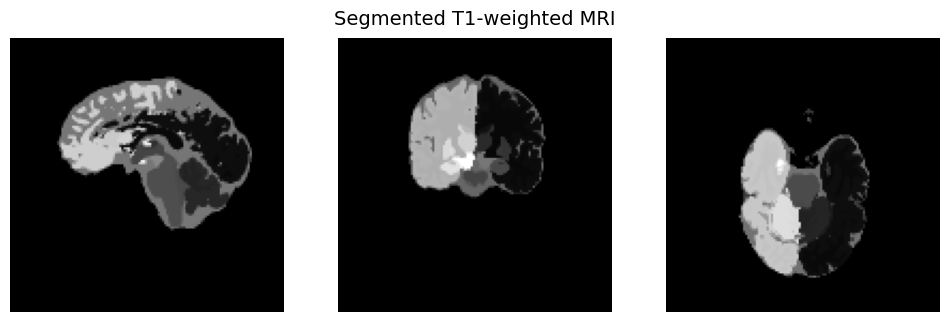

In [10]:
import utils_mri as utilmri
import os

# STEP 1:
# Segmentation with SynthSeg
NUMTHD = 4
out_dir = '.'

sub_id = "Img1"
sub_img = "./Img1_T1.nii.gz"

ref_id = "Img2"
ref_img = "./Img2_T1.nii.gz"

# Skull stripped images
# sub_id = "Img1"
# sub_img = "./Subj1_T1_LPS_dlicv.nii.gz"
# ref_id = "Img2"
# ref_img = "./colin27_t1_tal_lin.nii.gz"

# out_dir: "./out"

for tmp_id, tmp_img in [[sub_id, sub_img], [ref_id, ref_img]]:

    # Reorient images
    print('Reorienting image ...')
    out_sub = os.path.join(out_dir, 'reoriented', tmp_id)
    if not os.path.exists(out_sub):
        os.makedirs(out_sub)
    out_reorient = os.path.join(out_sub, tmp_id + '_T1_LPS.nii.gz')
    if not os.path.exists(out_reorient):
        utilmri.reorient_img(tmp_img, 'LPS', out_reorient)
    else:
        print(f'Out file exists, skip: {out_reorient}')

    # Segment image
    print('Segmenting image ...')
    out_sub = os.path.join(out_dir, 'segmented', tmp_id)
    if not os.path.exists(out_sub):
        os.makedirs(out_sub)
    out_seg = os.path.join(out_sub, tmp_id + '_Seg.nii.gz')
    out_qc = os.path.join(out_sub, tmp_id + '_Seg_QC.csv')
    out_vol = os.path.join(out_sub, tmp_id + '_Seg_Vol.csv')
    out_post = os.path.join(out_sub, tmp_id + '_Seg_Post.nii.gz')
    out_resample = os.path.join(out_sub, tmp_id + '_Seg_Resample.nii.gz')
    cmd = f'mri_synthseg --i {out_reorient} --o {out_seg} --robust --vol {out_vol} --qc {out_qc} --resample {out_resample} --threads {NUMTHD} --cpu'
    if not os.path.exists(out_seg):
        print(f'About to run: {cmd}')
        os.system(cmd)
    else:
        print(f'Out file exists, skip: {out_seg}')


t1_seg = sf.load_volume(out_seg).resize(voxsize=2).reshape(shape).reorient('ILP')

show(t1_seg, title='Segmented T1-weighted MRI')


In [11]:
# Shapes model. Assumes affine initialization and may require fine tuning.

print(f"The shape variable is: {shape}, and its type is: {type(shape)}")


model = vxm.networks.VxmDense(
    nb_unet_features=([256] * 4, [256] * 6),
    int_steps=5,
    int_resolution=2,
    svf_resolution=2,
    inshape=shape,
  )
model = tf.keras.Model(model.inputs, model.references.pos_flow)
model.load_weights('shapes-dice-vel-3-res-8-16-32-256f.h5')

The shape variable is: (128, 128, 128), and its type is: <class 'tuple'>


In [12]:
# CORRECTED CODE
# Shapes model. Assumes affine initialization and may require fine tuning.
vxm_model = vxm.networks.VxmDense(
    nb_unet_features=([256] * 4, [256] * 6),
    int_steps=5,
    int_resolution=2,
    svf_resolution=2,
    inshape=shape,
)

# Create a new model that takes the same inputs but only returns the second output (the pos_flow).
# This is the correct way to extract a part of the graph.
model_with_flow_output = tf.keras.Model(vxm_model.inputs, vxm_model.outputs[1])

# Now, load the weights into the ORIGINAL model that has the full architecture.
vxm_model.load_weights('shapes-dice-vel-3-res-8-16-32-256f.h5')

# Your new model `model_with_flow_output` will now work correctly because it shares
# weights with the fully-loaded vxm_model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
(128, 128, 128)
(1, 128, 128, 128, 1)


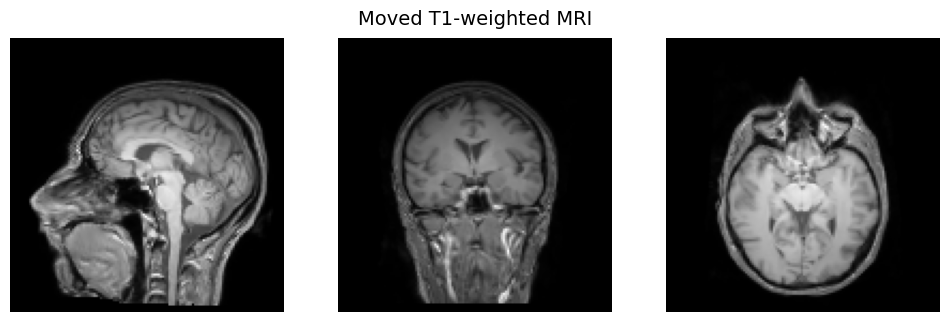

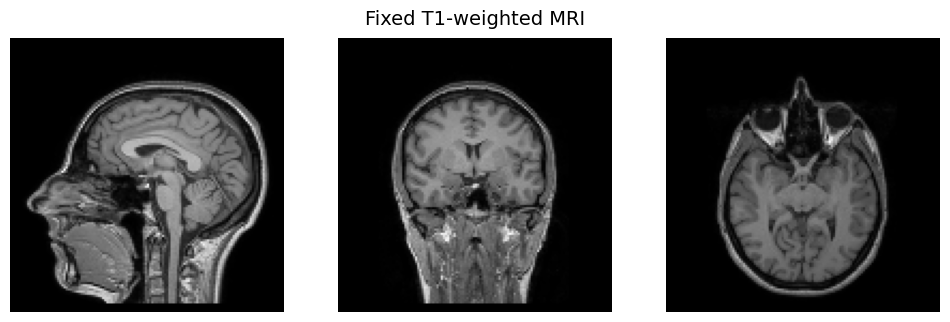

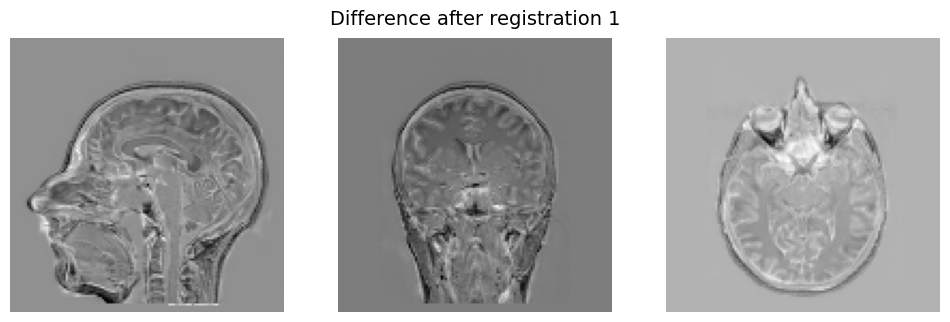

In [13]:
# STEP 2:
# Registration 1.
moving = normalize(t1_moving)
fixed = normalize(t1_fixed)
trans = model.predict((moving, fixed))

print(t1_moving.shape)
print(moving.shape)


moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))
show(moved, title='Moved T1-weighted MRI')
show(fixed, title='Fixed T1-weighted MRI')
show(moved - fixed, title='Difference after registration 1')

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 3)


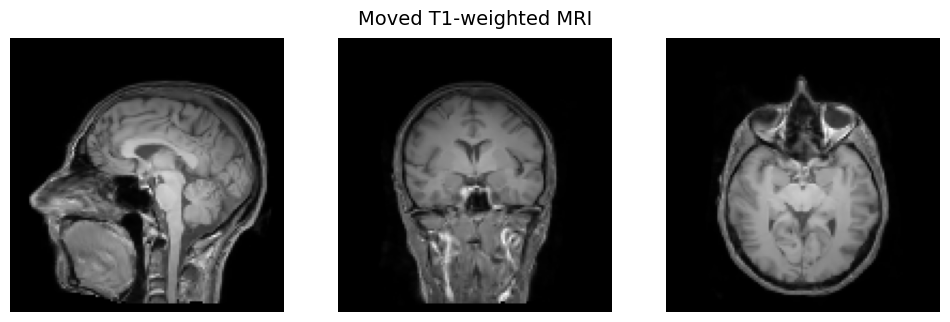

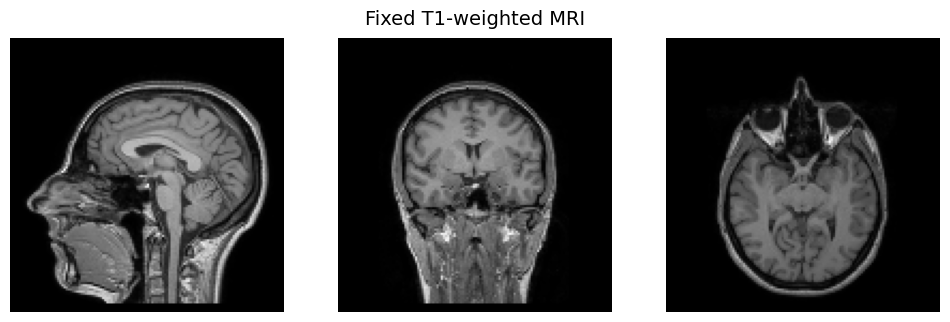

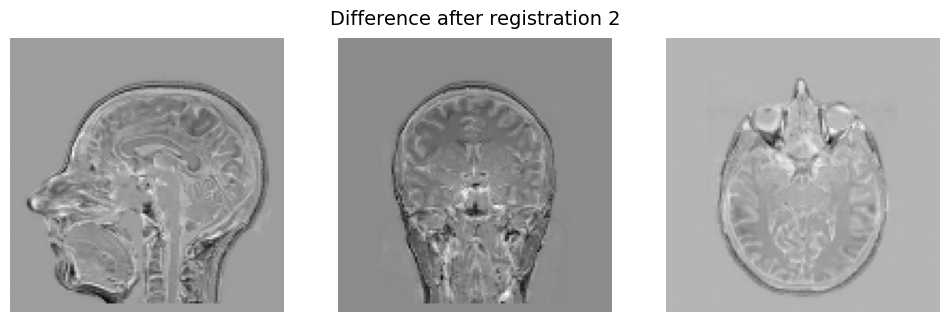

In [14]:
# # Registration 2.
resid = model.predict((moved, fixed))
trans = vxm.layers.ComposeTransform()((trans, resid))

print(moving.shape)
print(trans.shape)

moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))
show(moved, title='Moved T1-weighted MRI')
show(fixed, title='Fixed T1-weighted MRI')
show(moved - fixed, title='Difference after registration 2')

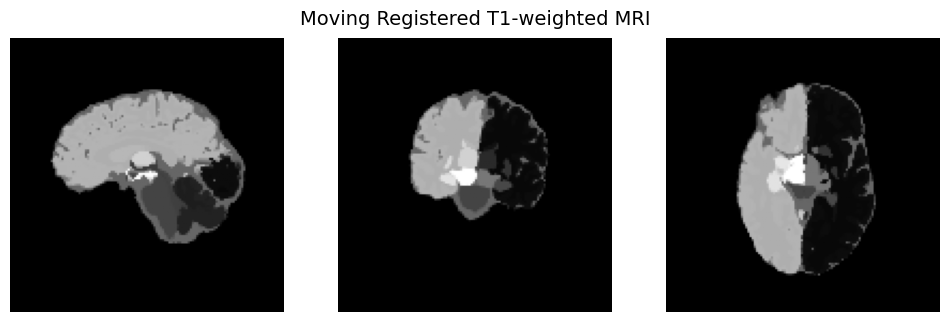

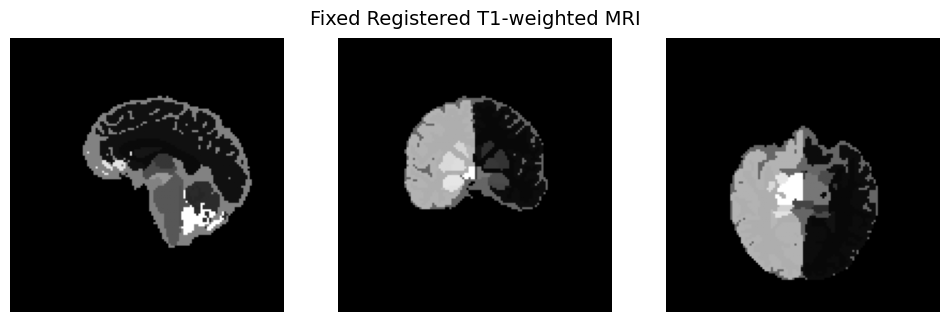

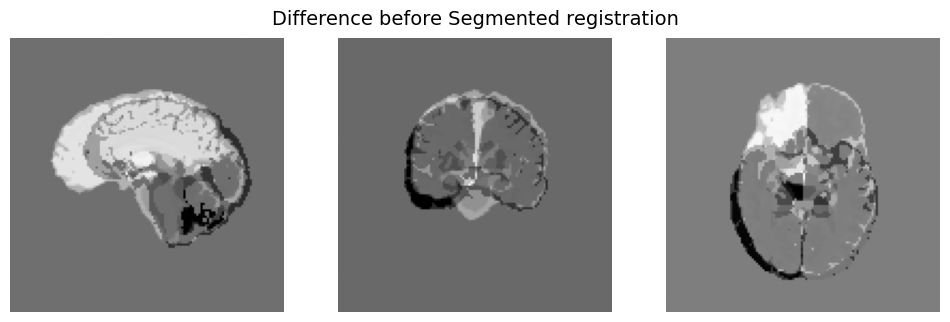

In [15]:
# Difference of Segmented images before registration.
t1_fixed_seg = sf.load_volume('segmented/Img1/Img1_Seg.nii.gz').resize(voxsize=2).reshape(shape).reorient('ILP')
# t1_moving_seg = sf.load_volume('segmented/Img2/Img2_Seg.nii.gz').resample_like(moving)
t1_moving_seg = sf.load_volume('segmented/Img2/Img2_Seg.nii.gz').resample_like(t1_fixed_seg)
before = normalize(t1_moving_seg) - normalize(t1_fixed_seg)

show(t1_moving_seg, title='Moving Registered T1-weighted MRI')
show(t1_fixed_seg, title='Fixed Registered T1-weighted MRI')
show(before, title='Difference before Segmented registration')

In [16]:
# # Registration of Segmented Image
# moving = normalize(t1_moving)
# fixed = normalize(t1_fixed)
# trans = model.predict((moving, fixed))

# # moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))
# moved = vxm.layers.SpatialTransformer(interp_method='nearest', fill_value=0)((moving, trans))
# show(moved, title='Moved Registered T1-weighted MRI')
# show(fixed, title='Fixed Registered T1-weighted MRI')
# show(moved - fixed, title='Difference after Segmented registration')

(128, 128, 128)
(1, 128, 128, 128, 3)


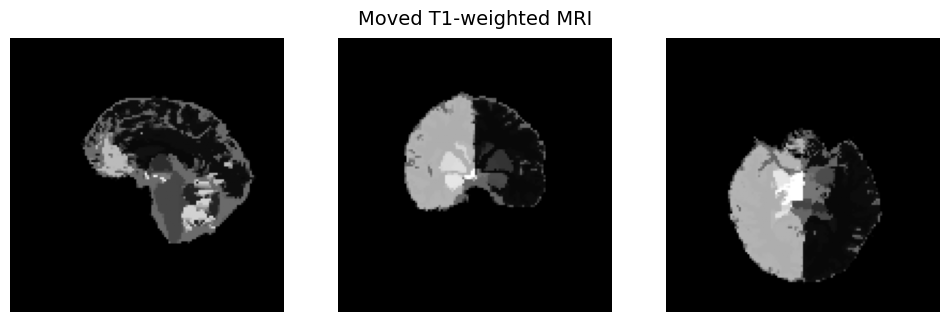

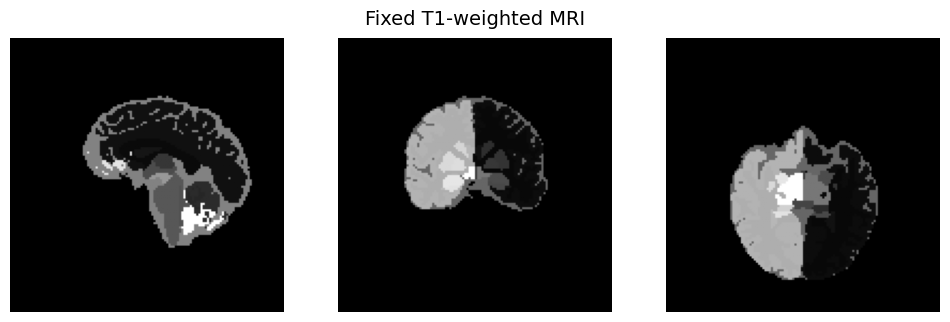

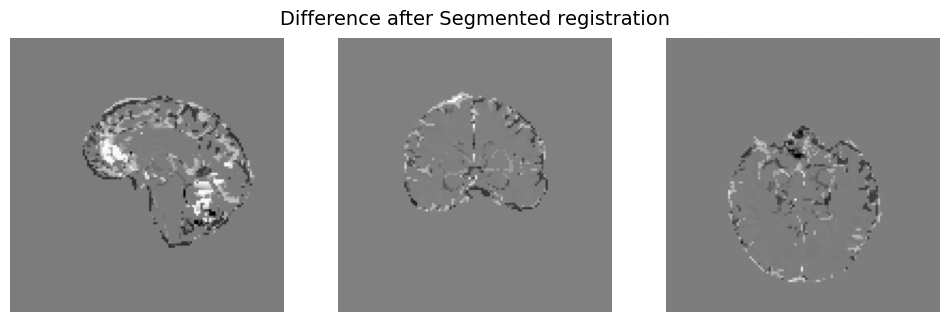

In [17]:
# # Registration 2.
# resid = model.predict((moved, fixed))
# trans = vxm.layers.ComposeTransform()((trans, resid))

# Use transformation from previous registration
print(t1_moving_seg.shape)
print(trans.shape)

moving_seg = normalize(t1_moving_seg)
fixed_seg = normalize(t1_fixed_seg)

moved_seg = vxm.layers.SpatialTransformer(interp_method='nearest', fill_value=0)((moving_seg, trans))
show(moved_seg, title='Moved T1-weighted MRI')
show(fixed_seg, title='Fixed T1-weighted MRI')
show(moved_seg - fixed_seg, title='Difference after Segmented registration')

In [18]:
# # Save results.
t1_fixed.new(moved_seg[0]).save('moved_seg.nii.gz')
sf.Warp(trans[0], source=t1_moving_seg, target=t1_fixed_seg, format=sf.Warp.Format.disp_crs).save('warp_seg.nii.gz')

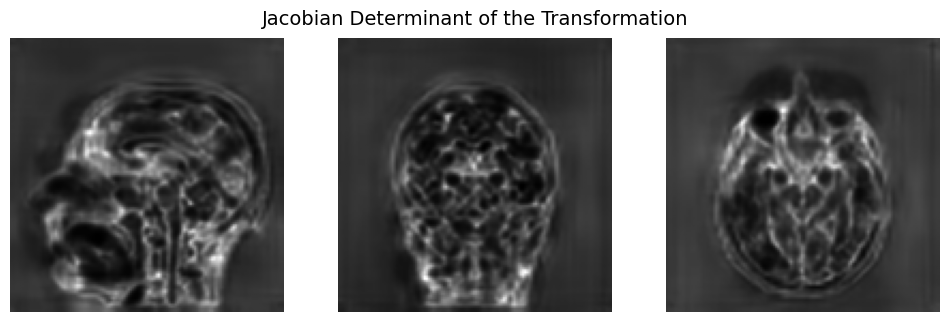

In [19]:
# Calculate the Jacobian

# Select the first element from the batch before calculating
jacobian_det = vxm.py.utils.jacobian_determinant(trans[0])

# The output of jacobian_determinant
show(jacobian_det, title='Jacobian Determinant of the Transformation')


In [20]:
t1_fixed.new(jacobian_det).save('jacobian_det.nii.gz')


In [21]:
import pandas as pd
import json
import os
import argparse
import nibabel as nib
import numpy as np
from nilearn import image

def calc_ravens(f_jac, f_seg, label, f_out):
    """
    Calculates a RAVENS map by masking a Jacobian determinant map with a specific label from a segmentation file.
    It handles cases where the jacobian and segmentation images are in different spaces by resampling the segmentation.
    """
    # Read the reference jacobian image (this defines our target space)
    nii_jac = nib.load(f_jac)
    img_jac = nii_jac.get_fdata()
    
    # Read the segmentation image that needs to be resampled
    nii_seg = nib.load(f_seg)
    
    # --- RESAMPLE NIFTI OBJECTS USING NILEARN ---
    # Resample the segmentation image to match the jacobian's space (affine and shape).
    # We use 'nearest' for the interpolation method. This is crucial for label maps,
    # as it ensures that no new, non-existent label values are created during resampling.
    print(f"Resampling segmentation from {nii_seg.shape} to {nii_jac.shape}...")
    nii_seg_resampled = image.resample_to_img(nii_seg, nii_jac, interpolation='nearest')
    
    # Now get the image data from the resampled NIfTI object
    img_seg_resampled = nii_seg_resampled.get_fdata()
    
    # Make mask for the desired label from the *resampled* segmentation
    mask = (img_seg_resampled == label).astype(np.uint8)
    
    # Check if the mask contains any voxels for the given label.
    if np.sum(mask) == 0:
        print(f"Warning: Label {label} not found in the segmentation file after resampling. The output will be empty.")
    
    # Calculate ravens by applying the mask to the jacobian image
    # This will set all voxels outside the mask to zero.
    ravens = img_jac * mask
    
    # Save the resulting RAVENS map as a new NIfTI image.
    # It's important to use the affine transformation from the reference image (the jacobian).
    nii_out = nib.Nifti1Image(ravens, nii_jac.affine)
    nib.save(nii_out, f_out)
    print(f"RAVENS map saved to: {f_out}")


# Example of how to run the function.
# I've corrected the output filename to have a proper NIfTI extension.
calc_ravens("jacobian_det.nii.gz", "segmented/Img1/Img1_Seg.nii.gz", 2, "ravens_out.nii.gz")
calc_ravens("jacobian_det.nii.gz", "segmented/Img1/Img1_Seg.nii.gz", 24, "ravens_out24.nii.gz")



Resampling segmentation from (180, 242, 242) to (128, 128, 128)...
RAVENS map saved to: ravens_out.nii.gz


Use 'force_resample=True' to suppress this warning.


Resampling segmentation from (180, 242, 242) to (128, 128, 128)...
RAVENS map saved to: ravens_out24.nii.gz


Use 'force_resample=True' to suppress this warning.


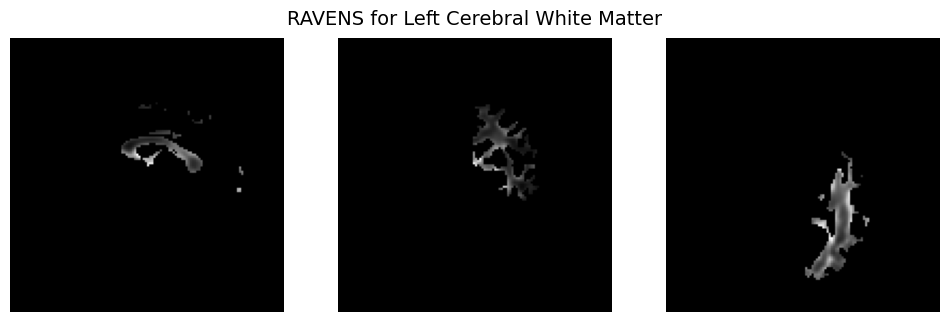

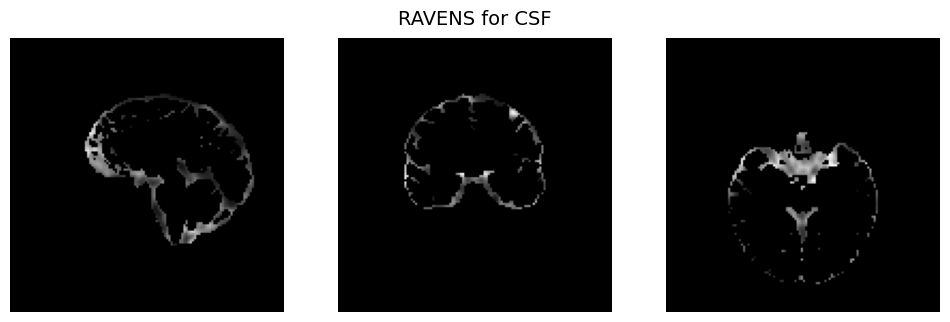

In [22]:
t1_rav = sf.load_volume('ravens_out.nii.gz')
show(t1_rav, title='RAVENS for Left Cerebral White Matter')

t1_rav = sf.load_volume('ravens_out24.nii.gz')
show(t1_rav, title='RAVENS for CSF')


In [23]:
# Log package versions.
!pip freeze

absl-py==2.3.0
aiobotocore @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b2htsn1rgl/croot/aiobotocore_1738237874912/work
aiohappyeyeballs @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b38qlemj37/croot/aiohappyeyeballs_1734469403568/work
aiohttp @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_44bhte2f2d/croot/aiohttp_1734692700992/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_39uesgct45/croot/alabaster_1718201495024/work
altair @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_80u2hc4yvg/croot/altair_1738916172872/work
anaconda-catalogs @ file:///Users/builder/cbouss/perseverance-python-buildout/croot/anaconda-catalogs_1701813581302/work
oot/annotated-types_1709542925772/workfolders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/ab